In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
# upload the dataset
df = pd.read_csv("/content/GlobalWeatherRepository.csv")

print(df.head())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

In [18]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Drop columns with too many missing values
df = df.drop(columns=[
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index'
])

# Fill remaining missing values with the mean for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Drop rows with missing values in critical columns
df = df.dropna(subset=['temperature_celsius', 'last_updated'])


Missing values in each column:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone

In [21]:
 #Normalize numerical data
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

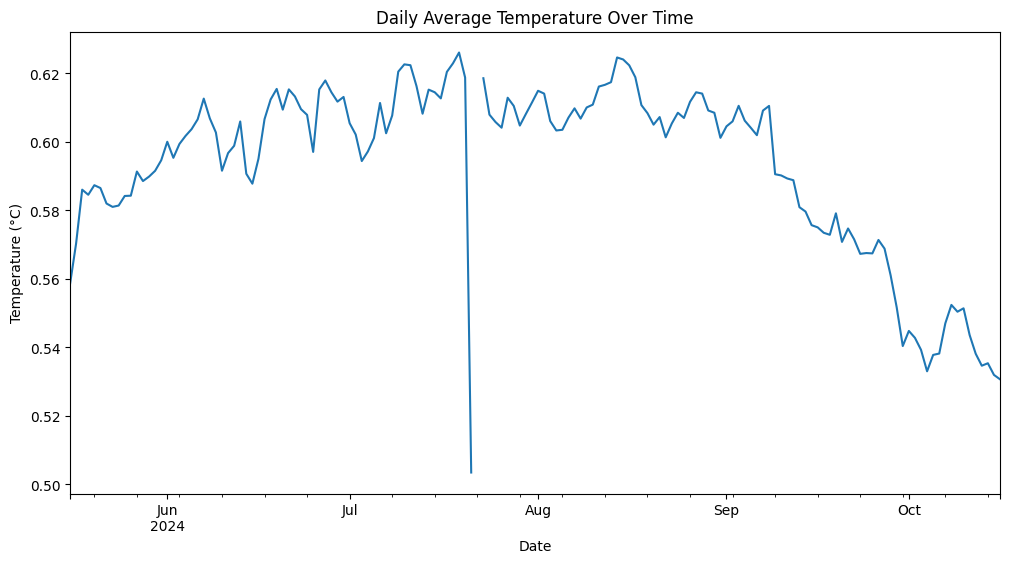

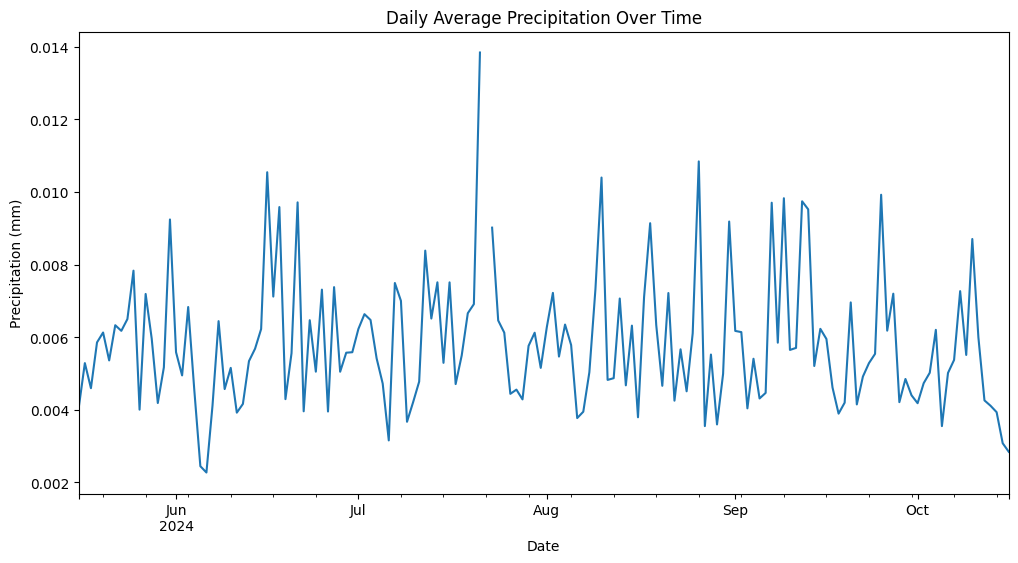

In [23]:
#Temperature trends over time
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)

plt.figure(figsize=(12, 6))
df['temperature_celsius'].resample('D').mean().plot()
plt.title("Daily Average Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

#Precipitation trends over time
plt.figure(figsize=(12, 6))
df['precip_mm'].resample('D').mean().plot()
plt.title("Daily Average Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

In [33]:
# Model Building
df['temperature_celsius'] = df['temperature_celsius'].fillna(df['temperature_celsius'].mean())

location_data = df[df['location_name'] == df['location_name'].unique()[0]]

ts_data = location_data[['temperature_celsius']]

train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

In [34]:
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Check for missing values in test and forecast
print("Missing values in test:", test.isnull().sum())
print("Missing values in forecast:", forecast.isnull().sum()) # Print this to check for NaNs in forecast

test['temperature_celsius'] = test['temperature_celsius'].fillna(train['temperature_celsius'].mean())
forecast = forecast.fillna(train['temperature_celsius'].mean())

# Evaluate the model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Missing values in test: temperature_celsius    0
dtype: int64
Missing values in forecast: 31
Mean Absolute Error (MAE): 0.06217361845584349
Root Mean Squared Error (RMSE): 0.07929826731180362


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


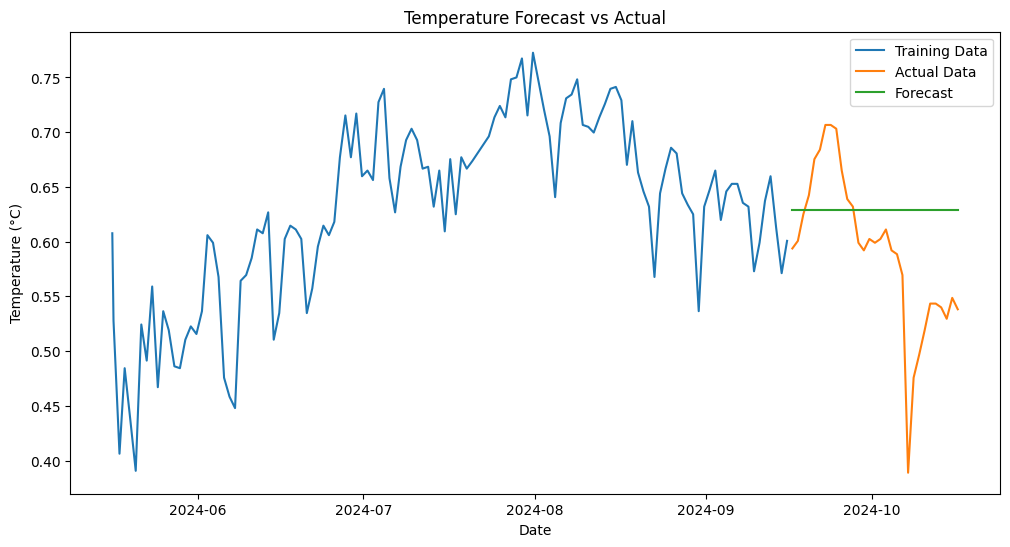

In [45]:
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast, label='Forecast')
plt.title("Temperature Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()